### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import logging
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PROJ_PATH,
                              PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel, PatchBiTModel, TilesModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy, TopkBCEWithLogitsLoss

# Optim
from chestxray.optimizers import RAdam

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [8]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


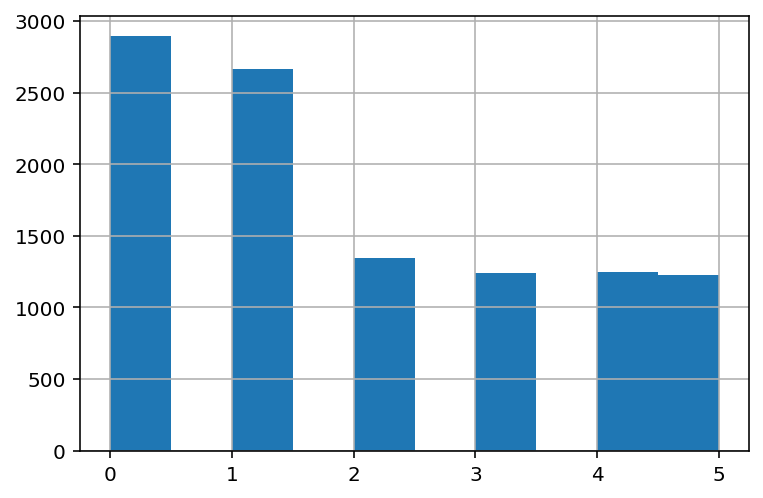

In [9]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [10]:
if CFG.debug:
    EXP_NAME = "debug"
    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    print(f"Start experiment: {EXP_NAME}")
else:
    if not CFG.resume:
        now = datetime.now()
        EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
        print(f"Start experiment: {EXP_NAME}")

        writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    else:
        # if resume should define from what to start
        PREV_NAME = CFG.prev_exp
        writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")

Start experiment: debug


In [11]:
# Set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

log_format = logging.Formatter('%(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(log_format)
logger.handlers = [stream_handler]
# add logging handler to save training to the file
log_fname = f"{PROJ_PATH/'logs'}/{EXP_NAME}.log"
file_handler = logging.FileHandler(log_fname, mode="a")
file_handler.setFormatter(log_format)
logger.handlers.append(file_handler)

In [12]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
    "bce" : TopkBCEWithLogitsLoss() if CFG.ohem else nn.BCEWithLogitsLoss(),
}

In [13]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type),
    "none": (None, None)
}

In [14]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, 
                                             cycle_momentum=False, final_div_factor=CFG.oc_final_div_factor),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [15]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds, targs = compute_preds(outputs, labels)
        preds_text = f"targs: {targs}, preds: {preds}"
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )
    def compute_preds(outputs, labels, loss_type=CFG.loss):
        if loss_type == "bce":
            preds = outputs.sigmoid().sum(1).data.cpu().round().numpy()
            targs = labels.sum(1).cpu().numpy()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
            targs = labels.to("cpu").numpy()
        return preds.astype(int), targs.astype(int)
        

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 30 times per full training
    vis_step = np.ceil(num_epochs / 30).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        logging.info(f"Epoch {epoch}/{num_epochs - 1}")
        logging.info("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        accum_train_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # then usimg accumulated gradients they sum up every loss.backward, we want mean of gradients
            # and so pararameter updates will be the same in case of accum_step > 1
            loss = criterion(outputs, labels) / accum_step
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            accum_train_loss += loss.item()
            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    scheduler.step()

                # loss is mean across batch, divide by number of steps in epoch
                # (so loss is normalized) + we only update train_running_loss every accum_step
                train_running_loss += accum_train_loss / (len(train_dataloader) / accum_step)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Training loss {tb_tag}",
                    scalar_value=accum_train_loss,
                    global_step=train_global_step,
                )
                # zero accum_train_loss 
                accum_train_loss = 0.

            # collect train preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            train_epoch_preds.append(preds)
            train_epoch_labels.append(targs)
            
        # Validation Phase
        # Set evaluation mode
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            if CFG.aux_tile:
                inp_main, inp_aux = inputs
                inp_main, inp_aux = inp_main.to(device), inp_aux.to(device)
            else:
                inputs = inputs.to(device)
            
            labels = labels.to(device)
            with torch.no_grad():
                if CFG.aux_tile:
                    out_main = model(inp_main)
                    out_aux = model(inp_aux)
                    outputs = (out_main + out_aux) / 2
                else:
                    outputs = model(inputs)
            if CFG.ohem:
                loss = criterion(outputs, labels, valid=True)
            else:
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Validation loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=val_global_step,
            )

            # collect validation preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            val_epoch_preds.append(preds)
            val_epoch_labels.append(targs)

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)

        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        logging.info(
            f"Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}"  # noqa
        )

        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        logging.info(
            f"Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}"  # noqa
        )
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(
            train_epoch_preds, train_epoch_labels, weights="quadratic"
        )
        val_qwk = cohen_kappa_score(
            val_epoch_preds, val_epoch_labels, weights="quadratic"
        )
        logging.info(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(
            tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch
        )
        writer.add_scalar(
            tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch
        )

        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            logging.info(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss,
                    "best_qwk": val_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "loss",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
            
        # On the best val loss do:
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            logging.info(f"  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": val_running_loss,
                    "best_qwk": best_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_qwk.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "qwk",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)

    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [16]:
CFG.debug = True

In [17]:
# That for the first time

In [28]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [29]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [17]:
if CFG.debug:
    folds = pd.read_csv(PANDA_PATH/"folds_db.csv")
else:
    folds = pd.read_csv(PANDA_PATH/"folds_dedup.csv")

In [18]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       500 non-null    object
 1   data_provider  500 non-null    object
 2   isup_grade     500 non-null    int64 
 3   gleason_score  500 non-null    object
 4   fold           500 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 19.7+ KB


In [19]:
folds = folds.sample(100)

### Init Data

In [20]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False, aux_tile=CFG.aux_tile)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False, aux_tile=CFG.aux_tile)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False, multi_lvl=CFG.multi_lvl)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False, multi_lvl=CFG.multi_lvl)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 10), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 10), pin_memory=True)

### Init Functions

In [21]:
def init_model(train_df=train_df, arch=CFG.arch, pre_init_fc_bias=CFG.pre_init_fc_bias, pretrained=True):
    if CFG.dataset == "patch":
        if arch == "efnet":
            model_ft = PatchEnetModel(backbone=CFG.enet_bone, pretrained=pretrained)
        elif arch == "bitM":
            model_ft = PatchBiTModel(pretrained=pretrained)
        else:
            model_ft = PatchModel(arch=CFG.arch, pretrained=pretrained)
            if pre_init_fc_bias:
                if CFG.loss in ["cce", "ls_soft_ce", "ohem"]:
                    # initialize bias in the model
                    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
                    model_ft = init_last_layer_bias(model_ft, cls_probas)
    elif CFG.dataset == "tiles":
        if arch in ["resnet50", "resnet34"]:
            model_ft = TilesModel(arch=arch, pretrained=pretrained)
        else:
            print(f"Tiles model for {arch} is not yet implemented!")
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=CFG.lr, amsgrad=False
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [22]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 224 img_width: 224 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 36 tile_sz: 224 batch_size: 8 accum_step: 1 dataset: tiles aux_tile: True aux_tile_sz: 168 aux_tile_num: 64 aug_type: light arch: resnet34 enet_bone: efficientnet-b0 finetune: False model_cls: one_layer pre_init_fc_bias: False ohem: True loss: bce optim: radam lr: 0.0003 schedule_type: one_cycle oc_final_div_factor: 10.0 cawr_T: 1 cawr_Tmult: 2 rlopp: 1 resume: False prev_exp: None from_epoch: 0 stage: 0 epoch: 50 n_fold: 4 use_amp: True descript: bce-ohem + rn34 + one cycle + 224x36 tiles + GEM


In [23]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=10)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 22-06-2020-18-20
Epoch 0/9


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 0/10 [00:00<?, ?it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 20%|██        | 2/10 [00:06<00:33,  4.17s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 3/3 [00:03<00:00,  1.19s/it]
Training Loss: 1.2063	Validation Loss: 0.4737
Counter train preds: Counter({3: 26, 4: 23, 2: 19, 1: 10, 5: 1})	Counter val preds: Counter({2: 12, 1: 9})
Epoch train QWK: 0.138	val QWK: -0.037
  Epoch 0 - Save Best Loss: 0.4737 Model
  Epoch 0 - Save Best QWK: -0.0370 Model


Normalized confusion matrix
[[0.  0.5 0.5 0.  0. ]
 [0.  0.6 0.4 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.5 0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]]


Epoch 1/9


Normalized confusion matrix
[[0.  0.5 0.5 0.  0. ]
 [0.  0.6 0.4 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.5 0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]]


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]
Training Loss: 0.8929	Validation Loss: 0.4649
Counter train preds: Counter({1: 51, 2: 27, 3: 1})	Counter val preds: Counter({2: 12, 1: 9})
Epoch train QWK: 0.078	val QWK: 0.015
  Epoch 1 - Save Best Loss: 0.4649 Model
  Epoch 1 - Save Best QWK: 0.0148 Model


Normalized confusion matrix
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.2        0.8        0.         0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]]


Epoch 2/9


Normalized confusion matrix
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.2        0.8        0.         0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]]


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]
Training Loss: 0.6935	Validation Loss: 0.5613
Counter train preds: Counter({2: 52, 1: 24, 3: 3})	Counter val preds: Counter({2: 18, 3: 2, 1: 1})
Epoch train QWK: 0.228	val QWK: 0.071
  Epoch 2 - Save Best QWK: 0.0708 Model
Epoch 3/9


Normalized confusion matrix
[[0.         0.         1.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.16666667 0.66666667 0.16666667 0.        ]
 [0.         0.         0.5        0.5        0.        ]
 [0.         0.         1.         0.         0.        ]]


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]
Training Loss: 0.6278	Validation Loss: 0.5595
Counter train preds: Counter({2: 38, 1: 22, 3: 18, 4: 1})	Counter val preds: Counter({2: 11, 3: 5, 1: 5})
Epoch train QWK: 0.377	val QWK: 0.163
  Epoch 3 - Save Best QWK: 0.1633 Model
Epoch 4/9


Normalized confusion matrix
[[0.         0.33333333 0.5        0.16666667 0.        ]
 [0.         0.         0.8        0.2        0.        ]
 [0.         0.5        0.33333333 0.16666667 0.        ]
 [0.         0.         0.5        0.5        0.        ]
 [0.         0.         0.5        0.5        0.        ]]


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
Training Loss: 0.5889	Validation Loss: 0.4553
Counter train preds: Counter({2: 38, 1: 23, 3: 14, 4: 4})	Counter val preds: Counter({2: 12, 1: 8, 3: 1})
Epoch train QWK: 0.438	val QWK: 0.066
  Epoch 4 - Save Best Loss: 0.4553 Model
Epoch 5/9


Normalized confusion matrix
[[0.         0.5        0.5        0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.66666667 0.16666667 0.16666667 0.        ]
 [0.         0.5        0.5        0.         0.        ]
 [0.         0.         1.         0.         0.        ]]


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]
Training Loss: 0.5701	Validation Loss: 0.4671
Counter train preds: Counter({1: 36, 2: 30, 3: 13})	Counter val preds: Counter({1: 11, 2: 9, 3: 1})
Epoch train QWK: 0.419	val QWK: 0.038
Epoch 6/9
100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
Training Loss: 0.5620	Validation Loss: 0.5034
Counter train preds: Counter({1: 33, 2: 23, 3: 20, 4: 2, 0: 1})	Counter val preds: Counter({2: 12, 1: 6, 3: 3})
Epoch train QWK: 0.557	val QWK: 0.064
Epoch 7/9
100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
Training Loss: 0.4604	Validation Loss: 0.4837
Counter train preds: Counter({2: 34, 1: 23, 3: 12, 4: 8, 0: 2})	Counter val preds: Counter({2: 14, 1: 4, 3: 3})
Epoch train QWK: 0.621	val QWK: 0.110
Epoch 8/9
100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
Training Loss: 0.4438	Validation Loss: 0.4785
Counter train preds: Counter({1: 33, 2: 25, 3: 11, 4: 7, 0: 3})	Counter val preds: Counter({1: 10, 2: 8, 3: 3})
Epoch train QWK: 0.639	val QWK: 0.194
  Epoch 8 - Sa

Normalized confusion matrix
[[0.         0.66666667 0.16666667 0.16666667 0.        ]
 [0.         0.2        0.8        0.         0.        ]
 [0.         0.66666667 0.16666667 0.16666667 0.        ]
 [0.         0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5        0.        ]]


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
Training Loss: 0.3564	Validation Loss: 0.4880
Counter train preds: Counter({1: 38, 2: 17, 3: 9, 4: 8, 0: 7})	Counter val preds: Counter({2: 13, 1: 5, 3: 3})
Epoch train QWK: 0.767	val QWK: 0.087
Finish: 22-06-2020-18-23


### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


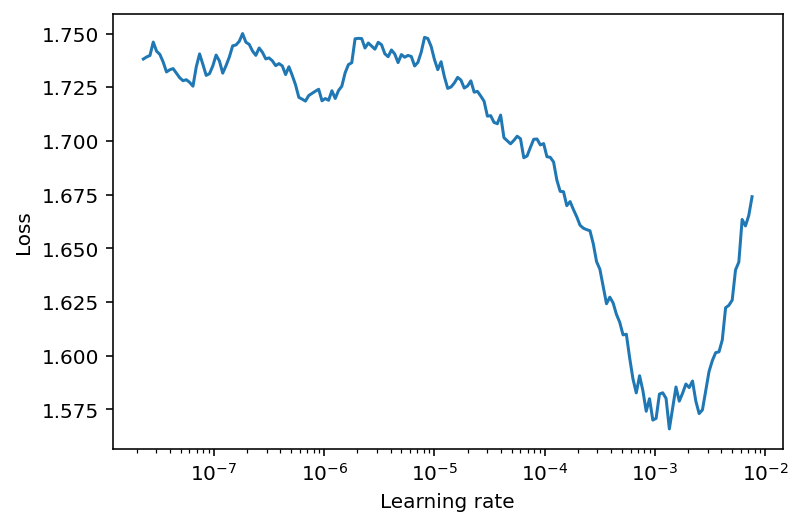

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [21]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 224
 img_width: 224
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 224
 batch_size: 8
 accum_step: 1
 dataset: tiles
 multi_lvl: False
 aug_type: light
 arch: resnet34
 enet_bone: efficientnet-b0
 finetune: False
 model_cls: one_layer
 pre_init_fc_bias: False
 ohem: True
 loss: bce
 optim: radam
 lr: 0.0003
 schedule_type: one_cycle
 oc_final_div_factor: 10.0
 cawr_T: 1
 cawr_Tmult: 2
 rlopp: 1
 resume: False
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 50
 n_fold: 4
 use_amp: True
 descript: bce-ohem + rn34 + one cycle + 224x36 tiles + GEM



In [22]:
writer.add_text("Experiment Description:", CFG.descript)

In [23]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)

In [24]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 21-06-2020-17-06
Epoch 0/49


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 0/943 [00:00<?, ?it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/943 [00:06<1:42:58,  6.56s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  0%|          | 2/943 [00:07<1:15:50,  4.84s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 316/316 [02:41<00:00,  1.96it/s]
Training Loss: 0.6821	Validation Loss: 0.4712
Counter train preds: Counter({2: 2586, 1: 2139, 3: 1885, 4: 664, 0: 211, 5: 55})	Counter val preds: Counter({2: 724, 1: 703, 3: 446, 4: 346, 0: 153, 5: 149})
Epoch train QWK: 0.429	val QWK: 0.667
  Epoch 0 - Save Best Loss: 0.4712 Model
  Epoch 0 - Save Best QWK: 0.6668 Model


Normalized confusion matrix
[[0.14606742 0.49438202 0.28089888 0.06320225 0.01404494 0.00140449]
 [0.06739812 0.39968652 0.42319749 0.10658307 0.0031348  0.        ]
 [0.01269841 0.19047619 0.37142857 0.33650794 0.08888889 0.        ]
 [0.         0.07241379 0.20689655 0.33448276 0.31724138 0.06896552]
 [0.00687285 0.02749141 0.17182131 0.29209622 0.37457045 0.12714777]
 [0.         0.02545455 0.09818182 0.16363636 0.38181818 0.33090909]]


Epoch 1/49


Normalized confusion matrix
[[0.14606742 0.49438202 0.28089888 0.06320225 0.01404494 0.00140449]
 [0.06739812 0.39968652 0.42319749 0.10658307 0.0031348  0.        ]
 [0.01269841 0.19047619 0.37142857 0.33650794 0.08888889 0.        ]
 [0.         0.07241379 0.20689655 0.33448276 0.31724138 0.06896552]
 [0.00687285 0.02749141 0.17182131 0.29209622 0.37457045 0.12714777]
 [0.         0.02545455 0.09818182 0.16363636 0.38181818 0.33090909]]


100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.5122	Validation Loss: 0.4831
Counter train preds: Counter({1: 2715, 2: 1977, 3: 1165, 4: 905, 0: 600, 5: 178})	Counter val preds: Counter({2: 1028, 3: 654, 4: 460, 5: 202, 1: 177})
Epoch train QWK: 0.659	val QWK: 0.533
Epoch 2/49
 12%|█▏        | 117/943 [01:09<07:06,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.4650	Validation Loss: 0.3057
Counter train preds: Counter({1: 2737, 2: 1839, 3: 1089, 4: 951, 0: 687, 5: 237})	Counter val preds: Counter({1: 866, 2: 540, 4: 402, 3: 348, 0: 326, 5: 39})
Epoch train QWK: 0.703	val QWK: 0.749
  Epoch 2 - Save Best Loss: 0.3057 Model
  Epoch 2 - Save Best QWK: 0.7492 Model


Normalized confusion matrix
[[0.39747191 0.53511236 0.05758427 0.00702247 0.00280899 0.        ]
 [0.05799373 0.52194357 0.38871473 0.02978056 0.0015674  0.        ]
 [0.00634921 0.20952381 0.47301587 0.27301587 0.03809524 0.        ]
 [0.         0.13103448 0.14482759 0.37586207 0.34827586 0.        ]
 [0.00343643 0.08247423 0.13745704 0.26116838 0.49140893 0.02405498]
 [0.01090909 0.08727273 0.07272727 0.19272727 0.52       0.11636364]]


Epoch 3/49


Normalized confusion matrix
[[0.39747191 0.53511236 0.05758427 0.00702247 0.00280899 0.        ]
 [0.05799373 0.52194357 0.38871473 0.02978056 0.0015674  0.        ]
 [0.00634921 0.20952381 0.47301587 0.27301587 0.03809524 0.        ]
 [0.         0.13103448 0.14482759 0.37586207 0.34827586 0.        ]
 [0.00343643 0.08247423 0.13745704 0.26116838 0.49140893 0.02405498]
 [0.01090909 0.08727273 0.07272727 0.19272727 0.52       0.11636364]]


100%|██████████| 316/316 [02:40<00:00,  1.96it/s]
Training Loss: 0.4472	Validation Loss: 0.2819
Counter train preds: Counter({1: 2665, 2: 1769, 3: 1148, 4: 976, 0: 769, 5: 213})	Counter val preds: Counter({1: 927, 0: 465, 2: 436, 4: 304, 3: 258, 5: 131})
Epoch train QWK: 0.720	val QWK: 0.795
  Epoch 3 - Save Best Loss: 0.2819 Model
  Epoch 3 - Save Best QWK: 0.7949 Model


Normalized confusion matrix
[[0.5758427  0.3988764  0.01966292 0.00421348 0.00140449 0.        ]
 [0.05956113 0.72100313 0.21473354 0.00470219 0.         0.        ]
 [0.01904762 0.3047619  0.48888889 0.13968254 0.04761905 0.        ]
 [0.02413793 0.11724138 0.22068966 0.35862069 0.25517241 0.02413793]
 [0.00687285 0.10996564 0.15120275 0.23367698 0.37457045 0.12371134]
 [0.00727273 0.07636364 0.08363636 0.13090909 0.38181818 0.32      ]]


Epoch 4/49


Normalized confusion matrix
[[0.5758427  0.3988764  0.01966292 0.00421348 0.00140449 0.        ]
 [0.05956113 0.72100313 0.21473354 0.00470219 0.         0.        ]
 [0.01904762 0.3047619  0.48888889 0.13968254 0.04761905 0.        ]
 [0.02413793 0.11724138 0.22068966 0.35862069 0.25517241 0.02413793]
 [0.00687285 0.10996564 0.15120275 0.23367698 0.37457045 0.12371134]
 [0.00727273 0.07636364 0.08363636 0.13090909 0.38181818 0.32      ]]


 32%|███▏      | 304/943 [03:06<06:19,  1.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:42<00:00,  1.95it/s]
Training Loss: 0.4181	Validation Loss: 0.2839
Counter train preds: Counter({1: 2574, 2: 1687, 3: 1118, 4: 995, 0: 931, 5: 235})	Counter val preds: Counter({1: 997, 2: 622, 3: 344, 4: 299, 0: 198, 5: 61})
Epoch train QWK: 0.749	val QWK: 0.753
Epoch 5/49
100%|██████████| 316/316 [02:42<00:00,  1.95it/s]
Training Loss: 0.4190	Validation Loss: 0.3046
Counter train preds: Counter({1: 2616, 2: 1676, 3: 1100, 4: 1000, 0: 915, 5: 233})	Counter val preds: Counter({1: 1110, 0: 461, 2: 330, 3: 255, 4: 251, 5: 114})
Epoch train QWK: 0.751	val QWK: 0.761
Epoch 6/49
 86%|████████▌ | 808/943 [07:40<01:20,  1.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.4040	Validation Loss: 0.2631
Counter train preds: Counter({1: 2523, 2: 1697, 4: 1041, 3: 1028, 0: 993, 5: 258})	Counter val preds: Counter({1: 832, 2: 606, 4: 358, 0: 340, 3: 304, 5: 81})
Epoch train QWK: 0.768	val QWK: 0.791
  Epoch 6 - Save Best Loss: 0.2631 Model
Epoch 7/49


Normalized confusion matrix
[[0.44241573 0.48595506 0.06460674 0.00561798 0.         0.00140449]
 [0.02351097 0.5830721  0.37774295 0.01410658 0.0015674  0.        ]
 [0.00952381 0.18412698 0.5968254  0.18095238 0.02857143 0.        ]
 [0.0137931  0.08965517 0.21724138 0.41034483 0.26206897 0.00689655]
 [0.00343643 0.05498282 0.17525773 0.26460481 0.4604811  0.04123711]
 [0.00727273 0.05090909 0.06181818 0.13818182 0.50181818 0.24      ]]


100%|██████████| 316/316 [02:36<00:00,  2.02it/s]
Training Loss: 0.3977	Validation Loss: 0.3621
Counter train preds: Counter({1: 2491, 2: 1662, 4: 1060, 0: 1034, 3: 1033, 5: 260})	Counter val preds: Counter({2: 932, 3: 516, 4: 495, 1: 433, 5: 137, 0: 8})
Epoch train QWK: 0.769	val QWK: 0.659
Epoch 8/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3876	Validation Loss: 0.3535
Counter train preds: Counter({1: 2481, 2: 1618, 0: 1091, 4: 1055, 3: 1021, 5: 274})	Counter val preds: Counter({2: 696, 1: 686, 4: 493, 3: 417, 5: 210, 0: 19})
Epoch train QWK: 0.783	val QWK: 0.728
Epoch 9/49
 24%|██▍       | 230/943 [02:07<06:10,  1.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3682	Validation Loss: 0.2732
Counter train preds: Counter({1: 2568, 2: 1473, 0: 1119, 4: 1103, 3: 990, 5: 287})	Counter val preds: Counter({1: 882, 2: 507, 4: 386, 3: 282, 5: 247, 0: 217})
Epoch train QWK: 0.802	val QWK: 0.802
  Epoch 9 - Save Best QWK: 0.8017 Model
Epoch 10/49


Normalized confusion matrix
[[0.29353933 0.62219101 0.0744382  0.00842697 0.00140449 0.        ]
 [0.00626959 0.54075235 0.40125392 0.05015674 0.0015674  0.        ]
 [0.0031746  0.14603175 0.41269841 0.2984127  0.13650794 0.0031746 ]
 [0.01034483 0.07241379 0.1        0.2862069  0.43103448 0.1       ]
 [0.         0.05154639 0.08591065 0.16151203 0.48109966 0.21993127]
 [0.         0.04363636 0.05090909 0.07272727 0.27636364 0.55636364]]


100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.3620	Validation Loss: 0.2798
Counter train preds: Counter({1: 2453, 2: 1496, 0: 1203, 4: 1061, 3: 1015, 5: 312})	Counter val preds: Counter({1: 1069, 2: 575, 3: 307, 4: 298, 0: 239, 5: 33})
Epoch train QWK: 0.808	val QWK: 0.759
Epoch 11/49
 91%|█████████ | 856/943 [07:35<00:45,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3527	Validation Loss: 0.2635
Counter train preds: Counter({1: 2440, 2: 1490, 0: 1221, 4: 1085, 3: 982, 5: 322})	Counter val preds: Counter({1: 772, 2: 668, 4: 386, 3: 315, 0: 221, 5: 159})
Epoch train QWK: 0.815	val QWK: 0.801
Epoch 12/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3408	Validation Loss: 0.2910
Counter train preds: Counter({1: 2417, 2: 1393, 0: 1328, 4: 1153, 3: 929, 5: 320})	Counter val preds: Counter({1: 899, 2: 533, 4: 422, 3: 309, 5: 271, 0: 87})
Epoch train QWK: 0.830	val QWK: 0.783
Epoch 13/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3370	Validation Loss: 0.2381
Counter train preds: Counter({1: 2395, 2: 1397, 0: 1327, 4: 1102, 3: 991, 5: 328})	Counter val preds: Counter({1: 891, 0: 467, 2: 388, 4: 345, 3: 227, 5: 203})
Epoch train QWK: 0.830	val QWK: 0.840
  Epoch 13 - Save Best Loss: 0.2381 Model
  Epoch 13 - Save Best QWK: 0.8403 Model


Normalized confusion matrix
[[0.61095506 0.34129213 0.04073034 0.00561798 0.00140449 0.        ]
 [0.02978056 0.77586207 0.17554859 0.01724138 0.0015674  0.        ]
 [0.00952381 0.31746032 0.46031746 0.17777778 0.03492063 0.        ]
 [0.02068966 0.07586207 0.1862069  0.3137931  0.35862069 0.04482759]
 [0.00343643 0.05841924 0.12027491 0.15463918 0.46391753 0.19931271]
 [0.01090909 0.05090909 0.04727273 0.07272727 0.33818182 0.48      ]]


Epoch 14/49


Normalized confusion matrix
[[0.61095506 0.34129213 0.04073034 0.00561798 0.00140449 0.        ]
 [0.02978056 0.77586207 0.17554859 0.01724138 0.0015674  0.        ]
 [0.00952381 0.31746032 0.46031746 0.17777778 0.03492063 0.        ]
 [0.02068966 0.07586207 0.1862069  0.3137931  0.35862069 0.04482759]
 [0.00343643 0.05841924 0.12027491 0.15463918 0.46391753 0.19931271]
 [0.01090909 0.05090909 0.04727273 0.07272727 0.33818182 0.48      ]]


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.3302	Validation Loss: 0.2523
Counter train preds: Counter({1: 2321, 0: 1440, 2: 1405, 4: 1112, 3: 893, 5: 369})	Counter val preds: Counter({1: 959, 2: 531, 4: 406, 3: 298, 0: 192, 5: 135})
Epoch train QWK: 0.839	val QWK: 0.803
Epoch 15/49
100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.3195	Validation Loss: 0.2409
Counter train preds: Counter({1: 2315, 0: 1447, 2: 1363, 4: 1094, 3: 947, 5: 374})	Counter val preds: Counter({1: 950, 0: 474, 2: 427, 4: 297, 3: 285, 5: 88})
Epoch train QWK: 0.847	val QWK: 0.821
Epoch 16/49
 16%|█▌        | 147/943 [01:24<06:47,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:38<00:00,  2.00it/s]
Training Loss: 0.3116	Validation Loss: 0.2371
Counter train preds: Counter({1: 2320, 0: 1515, 2: 1259, 4: 1125, 3: 944, 5: 377})	Counter val preds: Counter({1: 777, 0: 620, 2: 388, 4: 330, 3: 288, 5: 118})
Epoch train QWK: 0.855	val QWK: 0.830
  Epoch 16 - Save Best Loss: 0.2371 Model
Epoch 17/49


Normalized confusion matrix
[[0.77808989 0.20786517 0.01264045 0.00140449 0.         0.        ]
 [0.06269592 0.73197492 0.19749216 0.00783699 0.         0.        ]
 [0.01269841 0.31428571 0.45714286 0.18730159 0.02857143 0.        ]
 [0.04137931 0.08965517 0.19655172 0.40689655 0.25172414 0.0137931 ]
 [0.0137457  0.06872852 0.12371134 0.26804124 0.43986254 0.08591065]
 [0.02181818 0.06181818 0.05818182 0.09818182 0.43636364 0.32363636]]


 33%|███▎      | 313/943 [03:06<05:45,  1.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:40<00:00,  1.97it/s]
Training Loss: 0.3035	Validation Loss: 0.2299
Counter train preds: Counter({1: 2306, 0: 1522, 2: 1278, 4: 1113, 3: 950, 5: 371})	Counter val preds: Counter({1: 758, 0: 669, 4: 324, 2: 310, 3: 236, 5: 224})
Epoch train QWK: 0.861	val QWK: 0.852
  Epoch 17 - Save Best Loss: 0.2299 Model
  Epoch 17 - Save Best QWK: 0.8522 Model


Normalized confusion matrix
[[0.82724719 0.14747191 0.01544944 0.00983146 0.         0.        ]
 [0.0799373  0.76645768 0.13636364 0.01253918 0.00470219 0.        ]
 [0.01904762 0.33333333 0.4        0.20634921 0.03174603 0.00952381]
 [0.04137931 0.08965517 0.17241379 0.30344828 0.35517241 0.03793103]
 [0.02749141 0.06872852 0.10309278 0.1580756  0.4604811  0.18213058]
 [0.01090909 0.04727273 0.02181818 0.08       0.26909091 0.57090909]]


Epoch 18/49


Normalized confusion matrix
[[0.82724719 0.14747191 0.01544944 0.00983146 0.         0.        ]
 [0.0799373  0.76645768 0.13636364 0.01253918 0.00470219 0.        ]
 [0.01904762 0.33333333 0.4        0.20634921 0.03174603 0.00952381]
 [0.04137931 0.08965517 0.17241379 0.30344828 0.35517241 0.03793103]
 [0.02749141 0.06872852 0.10309278 0.1580756  0.4604811  0.18213058]
 [0.01090909 0.04727273 0.02181818 0.08       0.26909091 0.57090909]]


100%|██████████| 316/316 [02:36<00:00,  2.02it/s]
Training Loss: 0.2938	Validation Loss: 0.2300
Counter train preds: Counter({1: 2225, 0: 1619, 2: 1271, 4: 1130, 3: 875, 5: 420})	Counter val preds: Counter({1: 880, 0: 552, 2: 399, 4: 327, 3: 287, 5: 76})
Epoch train QWK: 0.870	val QWK: 0.837
Epoch 19/49
 97%|█████████▋| 915/943 [08:37<00:15,  1.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:39<00:00,  1.98it/s]
Training Loss: 0.2868	Validation Loss: 0.2335
Counter train preds: Counter({1: 2176, 0: 1673, 2: 1255, 4: 1133, 3: 880, 5: 423})	Counter val preds: Counter({1: 723, 0: 687, 4: 385, 2: 324, 3: 270, 5: 132})
Epoch train QWK: 0.877	val QWK: 0.843
Epoch 20/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.2744	Validation Loss: 0.2183
Counter train preds: Counter({1: 2167, 0: 1704, 2: 1228, 4: 1130, 3: 874, 5: 437})	Counter val preds: Counter({1: 869, 0: 536, 4: 328, 3: 323, 2: 318, 5: 147})
Epoch train QWK: 0.887	val QWK: 0.857
  Epoch 20 - Save Best Loss: 0.2183 Model
  Epoch 20 - Save Best QWK: 0.8567 Model


Normalized confusion matrix
[[0.6994382  0.25421348 0.03651685 0.00842697 0.00140449 0.        ]
 [0.03605016 0.82915361 0.12068966 0.01410658 0.         0.        ]
 [0.00952381 0.36190476 0.40952381 0.2031746  0.01587302 0.        ]
 [0.02413793 0.08965517 0.16551724 0.44827586 0.25517241 0.01724138]
 [0.00687285 0.03436426 0.09621993 0.28865979 0.4742268  0.09965636]
 [0.01090909 0.03272727 0.03636364 0.10909091 0.4        0.41090909]]


Epoch 21/49


Normalized confusion matrix
[[0.6994382  0.25421348 0.03651685 0.00842697 0.00140449 0.        ]
 [0.03605016 0.82915361 0.12068966 0.01410658 0.         0.        ]
 [0.00952381 0.36190476 0.40952381 0.2031746  0.01587302 0.        ]
 [0.02413793 0.08965517 0.16551724 0.44827586 0.25517241 0.01724138]
 [0.00687285 0.03436426 0.09621993 0.28865979 0.4742268  0.09965636]
 [0.01090909 0.03272727 0.03636364 0.10909091 0.4        0.41090909]]


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.2670	Validation Loss: 0.2251
Counter train preds: Counter({1: 2166, 0: 1735, 2: 1172, 4: 1145, 3: 876, 5: 446})	Counter val preds: Counter({1: 813, 0: 634, 2: 340, 4: 304, 3: 249, 5: 181})
Epoch train QWK: 0.891	val QWK: 0.852
Epoch 22/49
100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.2561	Validation Loss: 0.2333
Counter train preds: Counter({1: 2099, 0: 1811, 2: 1149, 4: 1124, 3: 875, 5: 482})	Counter val preds: Counter({1: 758, 0: 710, 2: 355, 3: 325, 4: 297, 5: 76})
Epoch train QWK: 0.900	val QWK: 0.836
Epoch 23/49
 51%|█████     | 477/943 [04:16<04:06,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.2457	Validation Loss: 0.2147
Counter train preds: Counter({1: 2125, 0: 1831, 4: 1138, 2: 1099, 3: 859, 5: 488})	Counter val preds: Counter({1: 742, 0: 612, 4: 354, 2: 334, 3: 263, 5: 216})
Epoch train QWK: 0.905	val QWK: 0.870
  Epoch 23 - Save Best Loss: 0.2147 Model
  Epoch 23 - Save Best QWK: 0.8700 Model


Normalized confusion matrix
[[0.78511236 0.17837079 0.02247191 0.01264045 0.00140449 0.        ]
 [0.05329154 0.77272727 0.14576803 0.02507837 0.0031348  0.        ]
 [0.01269841 0.27936508 0.46984127 0.18730159 0.04444444 0.00634921]
 [0.02758621 0.06206897 0.15862069 0.38275862 0.33448276 0.03448276]
 [0.01030928 0.03092784 0.0790378  0.1580756  0.5395189  0.18213058]
 [0.01454545 0.02545455 0.02909091 0.08       0.30181818 0.54909091]]


Epoch 24/49


Normalized confusion matrix
[[0.78511236 0.17837079 0.02247191 0.01264045 0.00140449 0.        ]
 [0.05329154 0.77272727 0.14576803 0.02507837 0.0031348  0.        ]
 [0.01269841 0.27936508 0.46984127 0.18730159 0.04444444 0.00634921]
 [0.02758621 0.06206897 0.15862069 0.38275862 0.33448276 0.03448276]
 [0.01030928 0.03092784 0.0790378  0.1580756  0.5395189  0.18213058]
 [0.01454545 0.02545455 0.02909091 0.08       0.30181818 0.54909091]]


100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.2465	Validation Loss: 0.2166
Counter train preds: Counter({1: 2109, 0: 1842, 2: 1119, 4: 1085, 3: 875, 5: 510})	Counter val preds: Counter({1: 859, 0: 592, 4: 319, 2: 302, 3: 275, 5: 174})
Epoch train QWK: 0.904	val QWK: 0.861
Epoch 25/49
100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.2359	Validation Loss: 0.2203
Counter train preds: Counter({1: 2095, 0: 1875, 4: 1115, 2: 1076, 3: 864, 5: 515})	Counter val preds: Counter({0: 691, 1: 635, 4: 340, 2: 324, 3: 323, 5: 208})
Epoch train QWK: 0.912	val QWK: 0.865
Epoch 26/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.2244	Validation Loss: 0.2183
Counter train preds: Counter({1: 2074, 0: 1920, 4: 1094, 2: 1047, 3: 876, 5: 529})	Counter val preds: Counter({1: 786, 0: 672, 3: 322, 2: 301, 4: 294, 5: 146})
Epoch train QWK: 0.920	val QWK: 0.863
Epoch 27/49
 75%|███████▌  | 711/943 [06:18<02:02,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:33<00:00,  2.05it/s]
Training Loss: 0.2183	Validation Loss: 0.2567
Counter train preds: Counter({1: 2031, 0: 1955, 4: 1086, 2: 1069, 3: 844, 5: 555})	Counter val preds: Counter({1: 595, 2: 551, 3: 427, 0: 399, 4: 327, 5: 222})
Epoch train QWK: 0.924	val QWK: 0.839
Epoch 28/49
100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.2042	Validation Loss: 0.2129
Counter train preds: Counter({1: 2043, 0: 1966, 4: 1092, 2: 1032, 3: 825, 5: 582})	Counter val preds: Counter({1: 745, 0: 652, 4: 354, 2: 336, 3: 271, 5: 163})
Epoch train QWK: 0.931	val QWK: 0.865
  Epoch 28 - Save Best Loss: 0.2129 Model
Epoch 29/49


Normalized confusion matrix
[[0.83005618 0.14747191 0.01825843 0.00280899 0.00140449 0.        ]
 [0.05642633 0.78213166 0.14420063 0.01567398 0.0015674  0.        ]
 [0.01904762 0.3015873  0.47301587 0.17142857 0.03174603 0.0031746 ]
 [0.03793103 0.07586207 0.16206897 0.43448276 0.27931034 0.01034483]
 [0.01718213 0.03780069 0.07560137 0.18900344 0.57731959 0.10309278]
 [0.01090909 0.04727273 0.04727273 0.08727273 0.33818182 0.46909091]]


 92%|█████████▏| 864/943 [08:12<00:43,  1.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:43<00:00,  1.93it/s]
Training Loss: 0.1975	Validation Loss: 0.2153
Counter train preds: Counter({1: 2036, 0: 1986, 4: 1068, 2: 998, 3: 855, 5: 597})	Counter val preds: Counter({1: 819, 0: 592, 2: 339, 4: 262, 3: 259, 5: 250})
Epoch train QWK: 0.933	val QWK: 0.873
  Epoch 29 - Save Best QWK: 0.8727 Model
Epoch 30/49


Normalized confusion matrix
[[0.77106742 0.1994382  0.01966292 0.00983146 0.         0.        ]
 [0.03448276 0.830721   0.11912226 0.01410658 0.0015674  0.        ]
 [0.01904762 0.34603175 0.47619048 0.12698413 0.02539683 0.00634921]
 [0.03103448 0.06551724 0.22068966 0.40689655 0.23793103 0.03793103]
 [0.01030928 0.03780069 0.08934708 0.20274914 0.42955326 0.23024055]
 [0.01090909 0.02909091 0.03272727 0.09454545 0.21454545 0.61818182]]


100%|██████████| 316/316 [02:39<00:00,  1.98it/s]
Training Loss: 0.1914	Validation Loss: 0.2178
Counter train preds: Counter({1: 2035, 0: 2001, 4: 1083, 2: 991, 3: 824, 5: 606})	Counter val preds: Counter({1: 763, 0: 691, 4: 350, 2: 279, 3: 258, 5: 180})
Epoch train QWK: 0.938	val QWK: 0.865
Epoch 31/49
100%|██████████| 316/316 [02:40<00:00,  1.97it/s]
Training Loss: 0.1821	Validation Loss: 0.2133
Counter train preds: Counter({1: 2032, 0: 2023, 4: 1084, 2: 964, 3: 824, 5: 613})	Counter val preds: Counter({1: 716, 0: 668, 2: 368, 4: 336, 3: 265, 5: 168})
Epoch train QWK: 0.942	val QWK: 0.870
Epoch 32/49
  5%|▌         | 50/943 [00:36<08:14,  1.81it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1793	Validation Loss: 0.2140
Counter train preds: Counter({0: 2053, 1: 1978, 4: 1067, 2: 979, 3: 850, 5: 613})	Counter val preds: Counter({0: 700, 1: 697, 2: 321, 4: 297, 5: 265, 3: 241})
Epoch train QWK: 0.944	val QWK: 0.874
  Epoch 32 - Save Best QWK: 0.8743 Model
Epoch 33/49


Normalized confusion matrix
[[0.88342697 0.09550562 0.01825843 0.00280899 0.         0.        ]
 [0.06269592 0.78056426 0.14263323 0.01253918 0.0015674  0.        ]
 [0.01904762 0.2952381  0.46984127 0.15873016 0.05079365 0.00634921]
 [0.04137931 0.06896552 0.14482759 0.39655172 0.26551724 0.08275862]
 [0.02405498 0.03780069 0.05498282 0.18213058 0.4742268  0.22680412]
 [0.02181818 0.02545455 0.04       0.04727273 0.23636364 0.62909091]]


100%|██████████| 316/316 [02:33<00:00,  2.05it/s]
Training Loss: 0.1651	Validation Loss: 0.2324
Counter train preds: Counter({0: 2077, 1: 1950, 4: 1037, 2: 992, 3: 826, 5: 658})	Counter val preds: Counter({1: 634, 0: 582, 4: 403, 2: 374, 3: 350, 5: 178})
Epoch train QWK: 0.951	val QWK: 0.865
Epoch 34/49
 20%|█▉        | 187/943 [01:44<06:31,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1603	Validation Loss: 0.2156
Counter train preds: Counter({0: 2056, 1: 2014, 4: 1047, 2: 939, 3: 832, 5: 652})	Counter val preds: Counter({1: 702, 0: 656, 2: 350, 3: 343, 4: 326, 5: 144})
Epoch train QWK: 0.954	val QWK: 0.869
Epoch 35/49
100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1520	Validation Loss: 0.2143
Counter train preds: Counter({0: 2074, 1: 1964, 4: 1022, 2: 999, 3: 810, 5: 671})	Counter val preds: Counter({1: 728, 0: 674, 4: 372, 2: 284, 3: 234, 5: 229})
Epoch train QWK: 0.957	val QWK: 0.878
  Epoch 35 - Save Best QWK: 0.8782 Model
Epoch 36/49


Normalized confusion matrix
[[0.86657303 0.10814607 0.01404494 0.00842697 0.00280899 0.        ]
 [0.05015674 0.80250784 0.12225705 0.02037618 0.00470219 0.        ]
 [0.01587302 0.32380952 0.41269841 0.19365079 0.04444444 0.00952381]
 [0.04137931 0.06551724 0.14137931 0.34482759 0.37241379 0.03448276]
 [0.01718213 0.03780069 0.05498282 0.13745704 0.57731959 0.17525773]
 [0.01090909 0.02545455 0.03272727 0.05090909 0.28       0.6       ]]


 34%|███▍      | 322/943 [02:56<05:17,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 943/943 [08:22<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1466	Validation Loss: 0.2237
Counter train preds: Counter({0: 2082, 1: 1995, 4: 1031, 2: 949, 3: 809, 5: 674})	Counter val preds: Counter({0: 742, 1: 604, 4: 352, 2: 334, 3: 263, 5: 226})
Epoch train QWK: 0.958	val QWK: 0.870
Epoch 37/49
100%|██████████| 316/316 [02:34<00:00,  2.05it/s]
Training Loss: 0.1422	Validation Loss: 0.2166
Counter train preds: Counter({0: 2086, 1: 1980, 4: 1014, 2: 926, 3: 856, 5: 678})	Counter val preds: Counter({0: 715, 1: 705, 2: 328, 4: 316, 3: 287, 5: 170})
Epoch train QWK: 0.961	val QWK: 0.869
Epoch 38/49
100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.1356	Validation Loss: 0.2159
Counter train preds: Counter({0: 2086, 1: 1973, 4: 1001, 2: 963, 3: 811, 5: 706})	Counter val preds: Counter({0: 707, 1: 703, 2: 322, 4: 302, 3: 285, 5: 202})
Epoch train QWK: 0.963	val QWK: 0.874
Epoch 39/49
100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.1300	Validation L

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1221	Validation Loss: 0.2239
Counter train preds: Counter({0: 2109, 1: 1959, 4: 1008, 2: 943, 3: 818, 5: 703})	Counter val preds: Counter({0: 711, 1: 648, 2: 348, 4: 337, 3: 277, 5: 200})
Epoch train QWK: 0.968	val QWK: 0.875
Epoch 42/49
100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.1198	Validation Loss: 0.2217
Counter train preds: Counter({0: 2109, 1: 1970, 4: 983, 2: 935, 3: 828, 5: 715})	Counter val preds: Counter({0: 738, 1: 682, 4: 322, 3: 301, 2: 295, 5: 183})
Epoch train QWK: 0.969	val QWK: 0.871
Epoch 43/49
 39%|███▉      | 372/943 [03:22<04:54,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1139	Validation Loss: 0.2176
Counter train preds: Counter({0: 2112, 1: 1948, 4: 958, 2: 942, 3: 844, 5: 736})	Counter val preds: Counter({0: 719, 1: 688, 4: 317, 2: 305, 3: 289, 5: 203})
Epoch train QWK: 0.971	val QWK: 0.874
Epoch 44/49
100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.1118	Validation Loss: 0.2233
Counter train preds: Counter({0: 2115, 1: 1962, 4: 991, 2: 926, 3: 830, 5: 716})	Counter val preds: Counter({0: 708, 1: 690, 2: 331, 3: 300, 4: 283, 5: 209})
Epoch train QWK: 0.972	val QWK: 0.875
Epoch 45/49
 65%|██████▍   | 610/943 [05:28<02:52,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:34<00:00,  2.04it/s]
Training Loss: 0.1125	Validation Loss: 0.2205
Counter train preds: Counter({0: 2122, 1: 1959, 4: 958, 2: 938, 3: 823, 5: 740})	Counter val preds: Counter({0: 723, 1: 662, 4: 326, 2: 319, 3: 280, 5: 211})
Epoch train QWK: 0.971	val QWK: 0.877
Epoch 46/49
100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1097	Validation Loss: 0.2226
Counter train preds: Counter({0: 2132, 1: 1946, 4: 962, 2: 928, 3: 838, 5: 734})	Counter val preds: Counter({0: 713, 1: 691, 4: 311, 2: 309, 3: 292, 5: 205})
Epoch train QWK: 0.972	val QWK: 0.874
Epoch 47/49
 79%|███████▉  | 745/943 [06:35<01:40,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:35<00:00,  2.04it/s]
Training Loss: 0.1077	Validation Loss: 0.2218
Counter train preds: Counter({0: 2115, 1: 1940, 4: 980, 2: 943, 3: 834, 5: 728})	Counter val preds: Counter({0: 707, 1: 689, 2: 317, 4: 315, 3: 297, 5: 196})
Epoch train QWK: 0.974	val QWK: 0.875
Epoch 48/49
100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1070	Validation Loss: 0.2212
Counter train preds: Counter({0: 2109, 1: 1964, 4: 981, 2: 938, 3: 825, 5: 723})	Counter val preds: Counter({0: 714, 1: 684, 2: 320, 4: 316, 3: 293, 5: 194})
Epoch train QWK: 0.973	val QWK: 0.877
Epoch 49/49
100%|██████████| 943/943 [08:18<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 316/316 [02:35<00:00,  2.03it/s]
Training Loss: 0.1102	Validation Loss: 0.2222
Counter train preds: Counter({0: 2115, 1: 1973, 4: 964, 2: 921, 3: 827, 5: 740})	Counter val preds: Counter({0: 716, 1: 664, 2: 331, 3: 311, 4: 306, 5: 193})
Epoch train QWK: 0.971	val QWK: 0.876
Finish: 22-06-2020-02-24


In [25]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [29]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [19]:
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_loss.pth")

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [26]:
model_fnames = [
    "21-06-2020-17-05_28_loss.pth",
    "21-06-2020-17-05_35_qwk.pth",
]

In [27]:
# Load Model/s
models = []
for name in model_fnames:
    model = init_model(pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [28]:
# models = []
# models.append(model_ft)

In [29]:
len(models)

2

In [30]:
def threshold(x: float) -> int:
    if x < 0.7:
        return 0
    elif x < 1.6:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    elif x < 4.4:
        return 4
    else:
        return 5
    
v_threshold = np.vectorize(threshold)

In [31]:
def compute_preds(outputs, loss_type=CFG.loss, custom_th=False):
        if loss_type == "bce":
            if custom_th:
                preds = outputs.sigmoid().sum(1).data.cpu().numpy()
                preds = v_threshold(preds)
            else:
                preds = outputs.sigmoid().sum(1).data.cpu().round().numpy()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
        return preds.astype(int)

In [32]:
TARGET_SZ = CFG.target_size

if CFG.loss == "bce":
    TARGET_SZ = CFG.target_size - 1
    
def inference(models, test_loader, device, *args, **kwargs):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []

    for i, data in enumerate(test_loader):
        images, _ = data    
        images = images.to(device)
        y_preds = torch.zeros((len(images), TARGET_SZ), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        pred = compute_preds(y_preds, *args, **kwargs)
        preds.append(pred)

    preds = np.concatenate(preds)
    
    return preds

In [33]:
def submit(sample, test_loader, models, *args, **kwargs):
    preds = inference(models, test_loader, device, *args, **kwargs)
    sample['isup_pred'] = preds
    return sample

In [34]:
# Use Custom Thresholds
CUSTOM_TH = False

In [35]:
val_df = submit(val_df, val_dataloader, models, custom_th=CUSTOM_TH)

In [36]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,isup_pred
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,4
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1
16,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,4
18,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,4


Normalized confusion matrix
[[0.85955056 0.11797753 0.01544944 0.00561798 0.00140449 0.        ]
 [0.05485893 0.80407524 0.12225705 0.01724138 0.0015674  0.        ]
 [0.01587302 0.3015873  0.45714286 0.18730159 0.03492063 0.0031746 ]
 [0.03793103 0.07241379 0.15172414 0.41034483 0.30344828 0.02413793]
 [0.0137457  0.04810997 0.05841924 0.1580756  0.59106529 0.13058419]
 [0.01090909 0.04       0.02545455 0.07272727 0.28727273 0.56363636]]


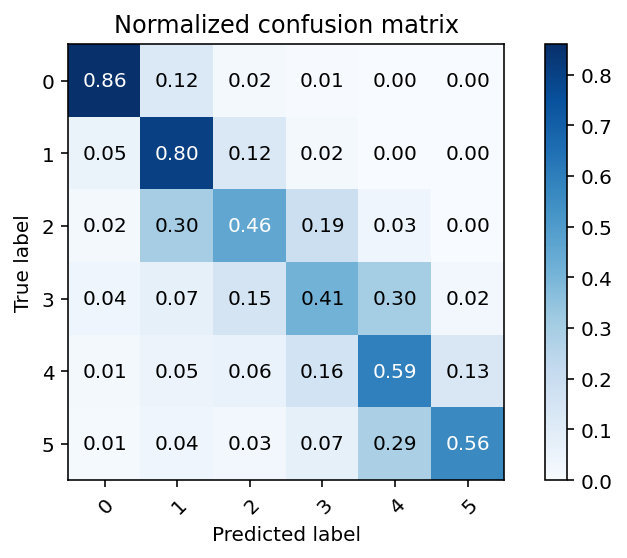

In [37]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [38]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [39]:
pred_kappa

0.8777606373515798

#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


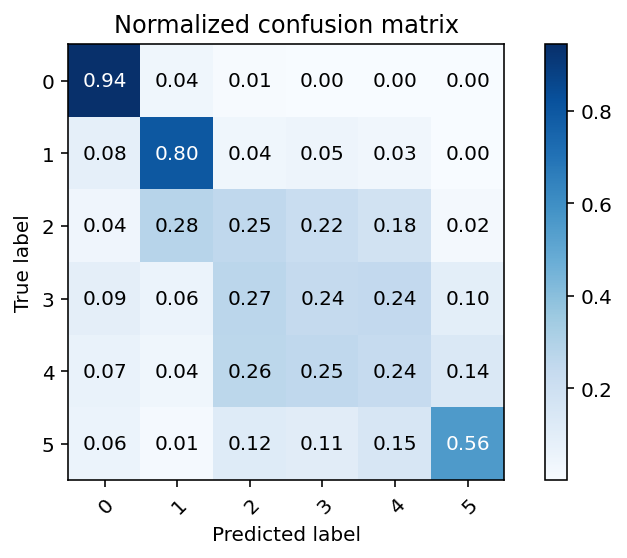

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
